# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 90% credible regions for the event, add them as a column to the data
- only keep data within the 90% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astropy import table

import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from scipy.stats import norm


from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import gasel as gs

Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [2]:
path = "/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/S230524bbayestar.multiorder.fits,1"
skymap = QTable.read(path)

skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1070,0.025102307158691887,1056.8693638771251,477.5750352152896,7.438482137484406e-07
1071,0.02146924958653858,1002.8049243502378,453.6163338562323,8.259288240366145e-07
1079,0.028719740292960014,1105.8403948495118,499.16954450010587,6.796689961007796e-07
1080,0.027035018766381314,1083.7831797972703,489.2770753376015,7.075848942846563e-07
1081,0.023985301491187418,1040.9304365221444,470.42485686691833,7.667739954604647e-07


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [3]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  25756


In [4]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  244.68749999999997 30.69158768492234 with prob [1/deg^2] of:  8.254542655096076e-05 and UNIQ ID:  25756


Now open the fits file and read basics info from the header

In [5]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  2436.6948033422 Mpc 890.9650450387676 Mpc


In [6]:
# these values (924, 188Mpc) are close to z= 0.19, 0.03

### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [8]:
desi_path = "/global/homes/j/jgassert/data.ecsv"
data = ascii.read(desi_path)

## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of z-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 90% credible region (i.e. with a certainty of 90% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [9]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64
-833389526,227.433272279891,66.6519046819295,20230427,1.1824834644376,9.79136990918098e-05,5,0.0,0.0,0.0,GALAXY,0,0.0290863439440727,0.0
-833389518,228.204498084663,66.7769162408949,20230427,1.01705132530733,0.000198853226529452,5,0.0,0.0,0.0,GALAXY,0,0.0315619334578514,0.0
-833389510,227.642453626374,66.7226250371644,20230427,1.20045807712059,0.000130270720806434,5,0.0,0.0,0.0,GALAXY,0,0.0310118906199932,0.0
-833389492,227.755926256736,66.7768026589679,20230427,1.39280058555401,0.000191373523674881,2053,0.0,0.0,0.0,GALAXY,0,0.0316010527312756,0.0
-833389491,227.851676937586,66.7933443247276,20230427,0.747688478964211,8.9141824351558e-05,5,0.0,0.0,0.0,GALAXY,0,0.0321089513599873,0.0


### data clean up

In [10]:
data = data[data["Z"]> 0]
data = data[data["ZWARN"] == 0]

In [11]:
data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [12]:
print(f"We have {len(data)} objects in the full catalog") 

We have 25324419 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [13]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

distmu = skymap[sorter_i]["DISTMU"]
distsigma = skymap[sorter_i]["DISTSIGMA"]
distnorm = skymap[sorter_i]["DISTNORM"]


In [14]:
# len(UNIQ), len(data), len(skymap)

In [15]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [16]:
data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])

In [17]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
39627267193704468,87.2931346460236,-21.8854203931447,20210116,1.54139764931006,6.51899837787448e-05,0,0.678932547569275,0.544187486171722,0.814229965209961,GALAXY,0,0.0382782742381096,1.0,37456,6.500068421559401e-05,2192.9073107829745,949.0797358089065,1.7520531310591857e-07
39627267193707272,87.3699284683912,-21.8766676366579,20210116,1.25698383007386,0.000243185890649753,0,1.8541316986084,1.37864375114441,1.71930611133575,QSO,0,0.0393409058451653,0.0,37114,6.467447055460739e-05,2189.0538766222107,947.6387785479297,1.7580954426518166e-07
39627267197895900,87.4762538649076,-21.8806878993573,20210116,0.126248515944835,1.06512530797224e-05,0,0.420664072036743,0.235325276851654,0.483817219734192,GALAXY,0,0.0426067262887955,0.0,37114,6.467447055460739e-05,2189.0538766222107,947.6387785479297,1.7580954426518166e-07
39627267197896032,87.4794499851022,-21.9167919737848,20210116,1.53241656944708,0.000234283455894663,0,0.668777704238892,0.317722111940384,0.890449166297913,QSO,0,0.0414619110524654,0.0,37114,6.467447055460739e-05,2189.0538766222107,947.6387785479297,1.7580954426518166e-07
39627267197896327,87.4883036183932,-21.9417798804529,20210116,1.45163923277157,0.000133357679299795,0,1.55398964881897,0.562485635280609,3.03630256652832,QSO,0,0.0413365438580513,0.0,37114,6.467447055460739e-05,2189.0538766222107,947.6387785479297,1.7580954426518166e-07


In [18]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probdensity)} and {np.max(probdensity)}")

The highest and lowest probability values in our catalog are: 6.142880107305406e-09 and 8.254542655096076e-05


### Sort the skymap table and get 90% credible region

In [19]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [20]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [21]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [22]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
25756,0.27098065044592196,2388.926527675562,1017.1124211340401,1.4838006844388912e-07
51091,0.27097594525954255,2388.9101041000754,1017.1085537910616,1.4838197000286126e-07
51097,0.2709669971211624,2388.8882395698406,1017.096493218224,1.483848082509022e-07
25753,0.27096521425247183,2388.88375273842,1017.0932278035259,1.4838542576981302e-07
51096,0.2709371553335126,2388.793100542863,1017.0650269219238,1.4839622686234683e-07


In [23]:
# now get 90% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.9
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.9)

# print area
area_90 = pixel_area[:i].sum()
area_90.to_value(u.deg**2)

24222.014600794282

### can be deleted, just tried things out

In [24]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [25]:
np.max(prob)

<Quantity 0.00012043>

In [26]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
25756,0.27098065044592196,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,6.927985194546647e-05
51091,0.27097594525954255,2388.9101041000754,1017.1085537910616,1.4838197000286126e-07,6.927864900121491e-05
51097,0.2709669971211624,2388.8882395698406,1017.096493218224,1.483848082509022e-07,6.927636128915448e-05
25753,0.27096521425247183,2388.88375273842,1017.0932278035259,1.4838542576981302e-07,6.927590547476804e-05
51096,0.2709371553335126,2388.793100542863,1017.0650269219238,1.4839622686234683e-07,6.926873183433267e-05


In [27]:
skymap_prob = Table(skymap_sort, copy = True)

In [28]:
skymap_prob.sort("PROB", reverse = True)

In [29]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
8544,0.11776428029029429,1783.708531171874,789.5436156070857,2.629252780209617e-07,0.00012043209564299407
1446,0.029409532289307604,1114.640854191237,503.1099743329846,6.689931772337782e-07,0.00012030308670000075
8098,0.11762319764051929,1783.0326307286564,789.2200268785671,2.6312728732083623e-07,0.0001202878169268215
10607,0.11761258452088137,1782.921407393565,789.2193917595281,2.6315486910123283e-07,0.00012027696337907211
11517,0.11757206049569427,1782.6897560729255,789.1416204602132,2.6322058845602873e-07,0.0001202355213283489


### Compare Tables, only leave 90% credible region in DESI data table

Now we can get a Table that only contains the 90% credible region. From there we only leave the matching objects in the DESI data

In [30]:
# we simply select only the entries that are within the 90% credible region
skymap_90 = skymap_sort[:i]

In [31]:
print("This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_90["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 7326


In [32]:
mask = np.in1d(data["UNIQ"], skymap_90["UNIQ"])
data_90 = data[mask]

In [33]:
print(f"We now have {len(data_90)} objects in the 90% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_90["TARGET_RA"]), np.max(data_90["TARGET_RA"]), np.min(data_90["TARGET_DEC"]), np.max(data_90["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_90["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 15720865 objects in the 90% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  1.84754109952898e-06 359.999921118173 -21.9997270654372 84.6091397280709
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is True


In [34]:
data_90.sort('PROBDENSITY', reverse=True)

In [35]:
data_90[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64
39628486893113662,244.411251099257,30.3267165582943,20220426,0.0936610071621255,2.52493092452139e-05,0,131.158737182617,60.6123695373535,224.047103881836,GALAXY,131074,0.0344885066151619,2.21570348739624,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07
39628492127604477,245.307895547923,30.620972877359,20220509,0.537347596528873,0.000100604088632446,0,7.80932760238647,1.82416248321533,20.5430908203125,GALAXY,0,0.0259376429021358,1.91903901100159,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07


In [36]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_90["Z"])
max_z = np.max(data_90["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 9.62592861409062e-11 to 6.94763515557217


### Calculate all the distances of the objects from the redshifts

In [37]:
distances = Distance(z=data_90["Z"], cosmology=Planck18)
distances_err = Distance(z=data_90["ZERR"], cosmology=Planck18)

data_90 = hstack([data_90, Table({"DIST_Z": distances}), Table({"DIST_Z_ERR": distances_err})])

In [38]:
data_90[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
39628486893113662,244.411251099257,30.3267165582943,20220426,0.0936610071621255,2.52493092452139e-05,0,131.158737182617,60.6123695373535,224.047103881836,GALAXY,131074,0.0344885066151619,2.21570348739624,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,443.7843040873353,0.11187849541970689
39628492127604477,245.307895547923,30.620972877359,20220509,0.537347596528873,0.000100604088632446,0,7.80932760238647,1.82416248321533,20.5430908203125,GALAXY,0,0.0259376429021358,1.91903901100159,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3183.067840381233,0.44579770965242405
39628481667011475,244.781498708761,30.1088742813958,20220605,0.803828109360517,0.000223876357473446,0,1.04229640960693,0.284002780914307,6.17165184020996,GALAXY,0,0.0326249301433563,4.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,5192.457817940395,0.9921365879996091
39628481667011429,244.779141401247,30.1122025883113,20220426,0.218085176477233,1.83461833434228e-05,0,12.1096172332764,5.6483359336853,20.7802448272705,GALAXY,65537,0.0325831398367882,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1115.2476430864715,0.08129064076428257
39628481667011370,244.775352030029,30.0979178915831,20210612,0.734322727766937,3.32787936656395e-05,0,0.902413070201874,0.633959770202637,1.84884560108185,GALAXY,0,0.0332439281046391,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,4648.432538171033,0.1474576688704485


### Lets check how much the distance measurement changes in the 90% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our distance ranges from 1231.695586160883 Mpc to 2388.926527675562 Mpc
Let's visualize the distance distribution of the LIGO event in the 90% credible region


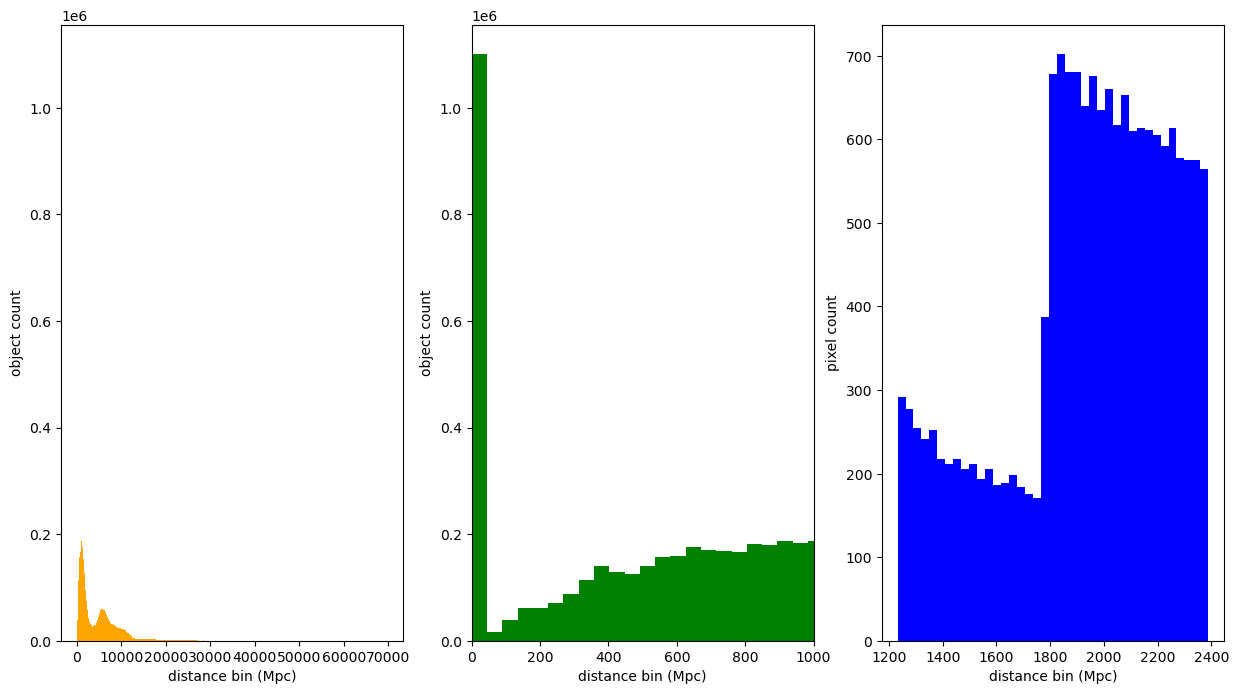

In [39]:
dist_max_90 = np.max(skymap_90["DISTMU"])*u.Mpc
dist_min_90 = np.min(skymap_90["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_90} to {dist_max_90}")
print("Let's visualize the distance distribution of the LIGO event in the 90% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_90["DIST_Z"], bins = "auto", color = "orange")
ax[1].hist(data_90["DIST_Z"], bins = "auto", color = "green")
ax[2].hist(skymap_90["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [40]:
len(skymap_90), len(data_90)

(16830, 15720865)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

In [41]:
z_selection_mask = data_90["DIST_Z"] - data_90["DIST_Z_ERR"] <  data_90["DISTMU"] + data_90["DISTSIGMA"]
z_selection_mask &= data_90["DIST_Z"] + data_90["DIST_Z_ERR"] >  data_90["DISTMU"] - data_90["DISTSIGMA"]

data_90_z = data_90[z_selection_mask]

In [42]:
remaining_obj = np.size(np.where(z_selection_mask == True))
deleted_obj = np.size(np.where(z_selection_mask == False))

print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
print(f"Therefore, we have {remaining_obj} objects left in the search region")

The z-range selection has deleted 11881226 objects from originally 15720865 in the data set
Therefore, we have 3839639 objects left in the search region


In [43]:
highest_prob_dens = np.max(data_90_z["PROBDENSITY"])
print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

Our highest remaing probability density is 8.254542655096076e-05 compared to the originally highest prob density of 8.254542655096076e-05
The difference in prob density is 0.0


In [44]:
data_90_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
39628492127604477,245.307895547923,30.620972877359,20220509,0.537347596528873,0.000100604088632446,0,7.80932760238647,1.82416248321533,20.5430908203125,GALAXY,0,0.0259376429021358,1.91903901100159,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3183.067840381233,0.44579770965242405
39628481667010741,244.738244165986,30.0821464191053,20220409,0.482245464163977,2.78865888908517e-06,0,0.757790982723236,0.724115133285522,1.12726938724518,GALAXY,0,0.0342096015810966,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,2796.1713160826607,0.01235620292853704
39628481667010679,244.734191806462,30.1026546552076,20230313,0.302325503238015,8.25472936412211e-05,0,14.4518594741821,3.29580330848694,35.8650207519531,GALAXY,65537,0.0332599431276321,4.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1616.831975582346,0.36577922047931694
39628481667010666,244.73340491721,30.0895851259223,20210523,0.294697065981468,8.49727923236266e-05,0,23.1262664794922,6.18275690078735,51.4869689941406,GALAXY,131074,0.0337170660495758,1.97284626960754,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1569.975437818251,0.3765276625451793
39628481667010360,244.715455110645,30.0430095295523,20210612,0.548183278809077,5.72508953941004e-05,0,0.553049504756927,0.55375611782074,0.795593678951263,GALAXY,0,0.0380657948553562,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3260.4265596967302,0.25368223363491066


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [46]:
# get the apparent mags
data_90_z = data_90_z[data_90_z["FLUX_Z"] > 0] # flux selection (only ones above 0)
data_90_z["MW_TRANSMISSION"] = data_90_z["EBV"]*gs.ext_coeffs[4]

#data_90_z["FLUX_Z"] = data_90_z["FLUX_Z"]/data_90_z["MW_TRANSMISSION"]

app_mag_z = gs.app_mag(data_90_z["FLUX_Z"])
flux_selection_cut = len(data_90_z)
print(f"We have {flux_selection_cut} objects remaining in our catalog, i.e. {remaining_obj-flux_selection_cut} had to be cut out due to bad fluxes")

# get the absolute mags
abs_mag_z = gs.abs_mag(app_mag_z, data_90_z["Z"], 0,0,0)

# get the luminosities
lums_z = gs.lum(abs_mag_z, band = "z")

/tmp/ipykernel_243156/973744509.py:5: RuntimeWarning: divide by zero encountered in divide
  data_90_z["FLUX_Z"] = data_90_z["FLUX_Z"]/data_90_z["MW_TRANSMISSION"]


We have 3839639 objects remaining in our catalog, i.e. 0 had to be cut out due to bad fluxes


In [47]:
data_f = hstack([data_90_z, Table({"APP_MAG_Z": app_mag_z}), Table({"ABS_MAG_Z": abs_mag_z}), Table({"LUM_Z": lums_z})])

In [48]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628492127604477,245.307895547923,30.620972877359,20220509,0.537347596528873,0.000100604088632446,0,7.80932760238647,1.82416248321533,654.0201610279872,GALAXY,0,0.0259376429021358,1.91903901100159,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3183.067840381233,0.44579770965242405,0.03141048555448646,15.461022159433032,-27.05320731452221,7.704146663667487e+38
39628481667010741,244.738244165986,30.0821464191053,20220409,0.482245464163977,2.78865888908517e-06,0,0.757790982723236,0.724115133285522,27.210439331991747,GALAXY,0,0.0342096015810966,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,2796.1713160826607,0.01235620292853704,0.041427827514707985,18.913161115422028,-23.31965776599428,2.47345903721282e+37
39628481667010679,244.734191806462,30.1026546552076,20230313,0.302325503238015,8.25472936412211e-05,0,14.4518594741821,3.29580330848694,890.4415994006762,GALAXY,65537,0.0332599431276321,4.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1616.831975582346,0.36577922047931694,0.040277791127562475,15.125986397379272,-25.917338050115056,2.706305599287603e+38
39628481667010666,244.73340491721,30.0895851259223,20210523,0.294697065981468,8.49727923236266e-05,0,23.1262664794922,6.18275690078735,1260.9660855035384,GALAXY,131074,0.0337170660495758,1.97284626960754,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1569.975437818251,0.3765276625451793,0.040831366986036295,14.748241484750364,-26.23122280499185,3.613522290258165e+38
39628481667010360,244.715455110645,30.0430095295523,20210612,0.548183278809077,5.72508953941004e-05,0,0.553049504756927,0.55375611782074,17.25886684304142,GALAXY,0,0.0380657948553562,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3260.4265596967302,0.25368223363491066,0.04609767756983636,19.40746930486162,-23.158902806526726,2.1330583641225773e+37


In [49]:
max_lum_z = np.max(data_f["LUM_Z"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_Z"] == max_lum_z]["PROBDENSITY"]
print(f"The maximum luminosity in our cataloge in the z-band is {max_lum_z} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our cataloge in the z-band is inf W with a prob density of      PROBDENSITY      
----------------------
  8.23262338870796e-05
 8.230851836134922e-05
 8.229449009409845e-05
 8.221459225861368e-05
  8.21641592452965e-05
  8.21641592452965e-05
  8.21641592452965e-05
  8.21641592452965e-05
  8.21641592452965e-05
  8.21641592452965e-05
                   ...
1.2089809415669354e-05
1.2089809415669354e-05
1.2089809415669354e-05
1.2089809415669354e-05
1.2089809415669354e-05
1.2089809415669354e-05
  1.20456668179492e-05
  1.20456668179492e-05
  1.20456668179492e-05
  1.20456668179492e-05
  1.20456668179492e-05
Length = 5875 rows


In [50]:
arg_errfc = abs(data_f["DIST_Z"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2)
P_gal_unnorm = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
#dist_mean*u.Mpc, dist_std*u.Mpc
arg_errfc_c = abs(data_f["DIST_Z"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2)
P_gal_unnorm_const = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

# now lets quickly normalize

P_gal_sum = np.sum(P_gal_unnorm)
P_gal_const_sum = np.sum(P_gal_unnorm_const)

P_gal = 1/P_gal_sum * P_gal_unnorm
P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

/tmp/ipykernel_243156/440661683.py:12: RuntimeWarning: invalid value encountered in multiply
  P_gal = 1/P_gal_sum * P_gal_unnorm
/tmp/ipykernel_243156/440661683.py:13: RuntimeWarning: invalid value encountered in multiply
  P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const


In [51]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value}), Table({"P_GAL_C": P_gal_const.value})])

In [52]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z,P_GAL,P_GAL_C
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W,,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,str6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628492127604477,245.307895547923,30.620972877359,20220509,0.537347596528873,0.000100604088632446,0,7.80932760238647,1.82416248321533,654.0201610279872,GALAXY,0,0.0259376429021358,1.91903901100159,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3183.067840381233,0.44579770965242405,0.03141048555448646,15.461022159433032,-27.05320731452221,7.704146663667487e+38,0.0,0.0
39628481667010741,244.738244165986,30.0821464191053,20220409,0.482245464163977,2.78865888908517e-06,0,0.757790982723236,0.724115133285522,27.210439331991747,GALAXY,0,0.0342096015810966,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,2796.1713160826607,0.01235620292853704,0.041427827514707985,18.913161115422028,-23.31965776599428,2.47345903721282e+37,0.0,0.0
39628481667010679,244.734191806462,30.1026546552076,20230313,0.302325503238015,8.25472936412211e-05,0,14.4518594741821,3.29580330848694,890.4415994006762,GALAXY,65537,0.0332599431276321,4.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1616.831975582346,0.36577922047931694,0.040277791127562475,15.125986397379272,-25.917338050115056,2.706305599287603e+38,0.0,0.0
39628481667010666,244.73340491721,30.0895851259223,20210523,0.294697065981468,8.49727923236266e-05,0,23.1262664794922,6.18275690078735,1260.9660855035384,GALAXY,131074,0.0337170660495758,1.97284626960754,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,1569.975437818251,0.3765276625451793,0.040831366986036295,14.748241484750364,-26.23122280499185,3.613522290258165e+38,0.0,0.0
39628481667010360,244.715455110645,30.0430095295523,20210612,0.548183278809077,5.72508953941004e-05,0,0.553049504756927,0.55375611782074,17.25886684304142,GALAXY,0,0.0380657948553562,1.0,25756,8.254542655096076e-05,2388.926527675562,1017.1124211340401,1.4838006844388912e-07,3260.4265596967302,0.25368223363491066,0.04609767756983636,19.40746930486162,-23.158902806526726,2.1330583641225773e+37,0.0,0.0


## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in z-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [53]:
N_galaxies = 20 # how many galaxies we can cover

In [54]:
total_lum = np.sum(data_f["LUM_Z"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [55]:
data_sort_by_lums = data_f.group_by("LUM_Z")
data_sort_by_lums = data_sort_by_lums[::-1]

In [56]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_Z"][:N_galaxies])

In [57]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is inf, i.e. nan % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39628072831422876
39628078766361072
39628049133601678
39628066930034838
39628060999289367
39628287755948749
39628287747559664
39628310262580324
39628293380509530
39628282114608580
39628304625436806
39628315857783850
39628321440400106
39628315832617588
39628315841006316
39628131903996585
39628131895610233
39628131912385768
39628131912386131
39628126040358994


/tmp/ipykernel_243156/122994387.py:1: RuntimeWarning: invalid value encountered in scalar divide
  print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")


### Compare lum with P_Gal ranking

In [58]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_Z"][:N_galaxies])

In [59]:
print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal is inf, i.e. nan% of the total luminosity
The TARGETID values of these galaxies are: 
     TARGET_RA        TARGET_DEC    SERSIC      TARGETID     P_GAL
----------------- ---------------- ------ ----------------- -----
0.499497905623266 11.9556911407253    0.0 39628072831422876   nan
 1.67465600203055 12.1612269823246    0.0 39628078766361072   nan
 1.31902584688177 10.9889575305807    0.0 39628049133601678   nan
 1.63484349280745 11.7065345718638    0.0 39628066930034838   nan
 1.18760702089412 11.4189097654077    0.0 39628060999289367   nan
 38.0353587787192 21.1287218277731    0.0 39628287755948749   nan
 37.4209905006093 21.2961460902493    0.0 39628287747559664   nan
 38.6530636537961 22.2313011323397    0.0 39628310262580324   nan
 37.2077303335268 21.4404783840671    0.0 39628293380509530   nan
 38.1807070911734  21.074220726112    0.0 39628282114608580   nan
 36.9856732102342 21.9071645488472    0.0 39628304625436806   nan
 3

/tmp/ipykernel_243156/3530422453.py:1: RuntimeWarning: invalid value encountered in scalar divide
  print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity")


In [60]:
data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_Z"][:N_galaxies])

In [61]:
print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal_C is inf, i.e. nan% of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID     P_GAL
----------------- -----
39628072831422876   nan
39628078766361072   nan
39628049133601678   nan
39628066930034838   nan
39628060999289367   nan
39628287755948749   nan
39628287747559664   nan
39628310262580324   nan
39628293380509530   nan
39628282114608580   nan
39628304625436806   nan
39628315857783850   nan
39628321440400106   nan
39628315832617588   nan
39628315841006316   nan
39628131903996585   nan
39628131895610233   nan
39628131912385768   nan
39628131912386131   nan
39628126040358994   nan


/tmp/ipykernel_243156/4279787764.py:1: RuntimeWarning: invalid value encountered in scalar divide
  print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity")


In [62]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write('PGAl_S200129.ecsv', delimiter=',', format='ascii', overwrite = False)


OSError: File PGAl_S200129.ecsv already exists. If you mean to replace it then use the argument "overwrite=True".